# Programming Exercise 3: Multi-class Classification and Neural Networks
# Introduction
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.
# 1 Multi-class Classification
For this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. In the first part of the exercise, we will extend your previous implemention of logistic regression and apply it to one-vs-all classification.
## 1.1 Dataset
We are given a data set in `ex3data1` that contains 5000 training examples of handwritten digits. The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into the program by using the `scipy.io.loadmat` command. After loading, matrices of the correct
dimensions and values will appear in your program’s memory. The matrix will already be named, so we do not need to assign names to them.

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$ X =
\begin{bmatrix}
    - (x^1)^T - \\   
    - (x^2)^T - \\   
      \vdots    \\
    - (x^m)^T -
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. To make things more compatible with Octave/MATLAB indexing, where there is no zero index, we have mapped the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9” in their natural order.

## 1.2 Visualizing the data
We will begin by visualizing a subset of the training set. The code below randomly selects selects 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. This is done through the `displayData` function.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.io
import scipy.optimize

In [2]:

def displayData(dataset, row=10, col=10, labels=None, title=None):
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(10, 10))
    if title: fig.suptitle(title)
    for r in range(row):
        for c in range(col):
            index = (r+1)*(c+1)-2
            digit = dataset[index].reshape(20, 20).T
            # generate the plot for one image
            axes[r, c].imshow(digit, cmap=plt.cm.binary)
            axes[r, c].axis('off')
            # print the labels
            try: axes[r, c].text(1, 3, str(labels[index]))
            except: pass
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

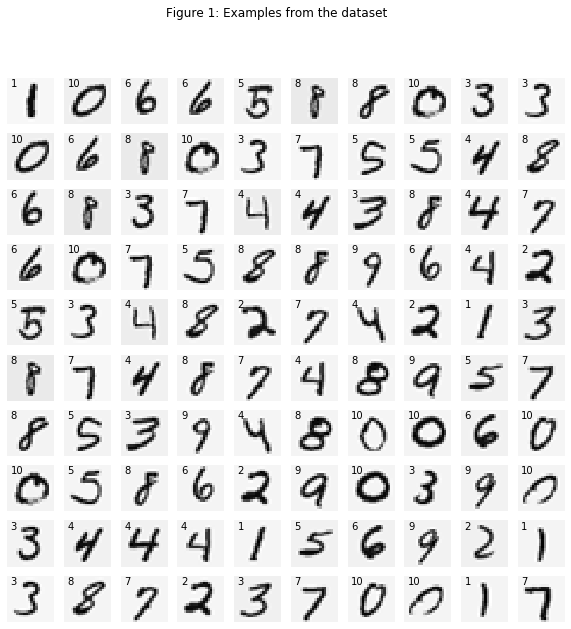

In [3]:
# Load saved matrices from file
mat = scipy.io.loadmat('ex3data1.mat')
X = mat['X']
y = mat['y'].T[0]

# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
num_labels = 10          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

# Randomly select 100 data points to display
m = X.shape[0]
rands = np.random.choice(m, 100)
X[rands]

# Display the data
displayData(X[rands], labels=y[rands], title="Figure 1: Examples from the dataset")

## 1.3 Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point
for this exercise.

### 1.3.1 Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is:

$$J(\theta) = {1 \over m} \sum_{i=1}^m [-y^i log(h_\theta(x^i)) - (1 - y^i) log(1 - h_\theta (x^i))]$$

To compute each element in the summation, we have to compute $h_\theta(x^i)$ for every example i, where $h_\theta(x^i) = g(\theta^T x^i)$ and $g(z) = {1 \over 1+e^{−z}}$ is the sigmoid function.

It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define X and θ as: 

$$ X =
\begin{bmatrix}
    - (x^1)^T - \\   
    - (x^2)^T - \\   
      \vdots    \\
    - (x^m)^T - \\
\end{bmatrix}
\ and \ \theta = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \vdots \\ \theta_m \end{bmatrix}$$

Then, by computing the matrix product Xθ, we have:
$$ X\theta = 
\begin{bmatrix}
    - (x^1)^T\theta - \\   
    - (x^2)^T\theta - \\   
      \vdots    \\
    - (x^m)^T\theta - \\
\end{bmatrix} = 
\begin{bmatrix}
    - \theta^T(x^1) - \\   
    - \theta^T(x^2) - \\   
      \vdots    \\
    - \theta^T(x^m) - \\
\end{bmatrix}
$$

In the last equality, we used the fact that $a^Tb = b^Ta$ if a and b are vectors. This allows us to compute the products $\theta^Tx^i$ for all our examples i in one line of code, as follows:

$$J(\theta) = {1 \over m} [-y \ log(h_\theta(X)) - (1 - y) log(1 - h_\theta(X))]$$

or


$$J(\theta) = {1 \over m} [-y \ log(g(X.\theta)) - (1 - y) log(1 - g(X.\theta))]$$

We write the unregularized cost function `lrCostFunction`. The implementation should use the strategy presented above to calculate $\theta^Tx^i$.

We should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

### 1.3.2 Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^th$ element is defined as:

$${\partial J \over \partial \theta_j} = {1 \over m} \sum_{i=1}^m (h_\theta(x^i) - y^i) x_j^i$$

The vectorized version can be written as:

$${\partial J \over \partial \theta_j} = {1 \over m} X^T (h_\theta(X) - y)$$ 
or 
$$ {\partial J \over \partial \theta_j} = {1 \over m} X^T (g(X.\theta) - y)$$

### 1.3.3 Vectorizing regularized logistic regression
After implementin vectorization for logistic regression, we can add regularization to the cost, and gradient functions to complete the implementation.

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def hypothesis(X, theta):
    return sigmoid(X.dot(theta))

def cost_lr_reg(X, y, theta, lam=0):
    m = X.shape[0]
    hypo = hypothesis(X, theta)
    costs = -y * np.log(hypo) - (1 - y) * np.log(1 - hypo)
    penalties = 0.5 * lam * theta[1:]**2
    return (sum(costs) + sum(penalties)) / m

def gradient_reg(X, y, theta, lam=0):
    gradients = []
    m = len(y)
    hypo = hypothesis(X, theta)
    for j in range(len(theta)):
        g = (hypo - y).dot(X[:, j]) / m
        # adding the regularization penalty
        p = 0
        if j > 0: p = lam * theta[j] / m
        gradients.append(g + p)
    return np.array(gradients)

def gradient_reg_vec(X, y, theta, lam=0):
    m = len(y)
    hypo = hypothesis(X, theta)
    gradients = X.T.dot(hypo - y) / m
    penalties = np.append(0, lam * theta[1:]) / m
    return gradients + penalties

def lrCostFunction(theta, X, y, lam):
    return cost_lr_reg(X, y, theta, lam), gradient_reg_vec(X, y, theta, lam)

In [5]:
# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization');

theta_t = np.array([-2, -1, 1, 2])
X_t = np.arange(1, 15+1).reshape(3, 5).T / 10
X_t = np.append(np.vstack(np.ones(5)), X_t, axis=1)
y_t = (np.array([1, 0, 1, 0, 1]) > 0.5) + 0
lambda_t = 3
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('\nCost: %f'% J)
print('Expected cost: 2.534819\n')
print('Gradients:')
print(' %s \n' % grad)
print('Expected gradients:')
print(' 0.146561 -0.548558 0.724722 1.398003\n')


Testing lrCostFunction() with regularization

Cost: 2.534819
Expected cost: 2.534819

Gradients:
 [ 0.14656137 -0.54855841  0.72472227  1.39800296] 

Expected gradients:
 0.146561 -0.548558 0.724722 1.398003



## 1.4 One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset (Figure 1). In the handwritten digits dataset, K = 10, but your code should work for any value of K.

The function `oneVsAll` trains one classifier for each class. The code should return all the classifier parameters
in a matrix Θ ∈ $\mathbb{R}^{K\times(N+1)}$ , where each row of Θ corresponds to the learned logistic regression parameters for one class. We can do this with a for-loop from 1 to K, training each classifier independently.

Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit “0” to the label 10 (to avoid confusions with indexing).

When training the classifier for class k ∈ {1, ..., K}, you will want a mdimensional vector of labels y, where $y_j$ ∈ 0, 1 indicates whether the j-th training instance belongs to class k ($y_j$ = 1), or if it belongs to a different class ($y_j$ = 0). You may find logical arrays helpful for this task

In [6]:
# helper function
def padOnes(X):
    m = len(X) # number of observations
    ones = np.vstack(np.ones(m))
    return np.append(ones, X, axis=1)

# define cost as a partial function so that we can pass it to the optimization function
def partial_cost(X, y, lam=0):
    def on(theta):
        m = X.shape[0]
        hypo = hypothesis(X, theta)
        costs = -y * np.log(hypo) - (1 - y) * np.log(1 - hypo)
        penalties = 0.5 * lam * theta[1:]**2
        return (sum(costs) + sum(penalties)) / m
    return on

In [7]:
def oneVsAll(X, y, num_labels, lam):
    """
    ONEVSALL trains multiple logistic regression classifiers and returns all 
    the classifiers in a matrix all_theta, where the i-th row of all_theta 
    corresponds to the classifier for label i
       [all_theta] = ONEVSALL(X, y, num_labels, lambda) trains num_labels
       logistic regression classifiers and returns each of these classifiers
       in a matrix all_theta, where the i-th row of all_theta corresponds 
       to the classifier for label i
    """

    # Some useful variables
    m, n = X.shape
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1));
    # Add ones to the X data matrix
    paddedX = padOnes(X)
    # inital theta
    theta0 = np.zeros(n + 1)
    for i in range(1, num_labels+1):
        logical_y = np.array((y==i) + 0)
        theta_optimum = scipy.optimize.minimize(partial_cost(paddedX, logical_y), theta0)
        print(theta_optimum)
        all_theta[i, :] = theta_optimum
    
    return all_theta

In [8]:
paddedX = padOnes(X)
logical_y = np.array((y==1) + 0)
theta0 = np.zeros(paddedX.shape[1])
#scipy.optimize.minimize(partial_cost(paddedX, logical_y), theta0)

In [9]:
#scipy.optimize.fmin_cg(partial_cost(paddedX, logical_y), theta0)